- DUBREUIL Jules
- ZHANG Kate

# Outlook #

In this colab we will study basic reinforcement learning algorithms: TD learning, q-learning and sarsa. We will also investigate two basic exploration strategies: $\epsilon$-greedy and softmax.

# Installation #

In [1]:
!pip install git+https://github.com/osigaud/SimpleMazeMDP

  Cloning https://github.com/osigaud/SimpleMazeMDP to /tmp/pip-req-build-sslmybsf
  Running command git clone -q https://github.com/osigaud/SimpleMazeMDP /tmp/pip-req-build-sslmybsf


In [2]:
import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from mazemdp.toolbox import egreedy, egreedy_loc, softmax
from mazemdp.maze import build_maze, create_random_maze
from mazemdp.maze_plotter import show_videos
from mazemdp.mdp import Mdp

# For visualization
os.environ["VIDEO_FPS"] = "5"

Matplotlib backend: module://ipykernel.pylab.backend_inline


# Reinforcement Learning #


Reinforcement Learning is about finding the optimal policy in an MDP which is initially unknown to the agent. More precisely, the state and action spaces are known, but the agent does not know the transition and reward functions. Generally speaking, the agent has to explore the MDP to figure out which action in which state leads to which other state and reward. The model-free case is about finding this optimal policy just through very local updates, without storing any information about previous interactions with the environment. Principles of these local updates can already be found in the Temporal Difference (TD) algorithm, which iteratively computes optimal values for all state using local updates.
The most widely used model-free RL algorithms are **q-learning**, **sarsa** and **actor-critic** algorithms. Below we focus on the first two.

As for dynamic programming, we first create a maze-like MDP. Reinforcement learning is slower than dynamic programming, so we will work with smaller mazes.

In [3]:
from mazemdp import create_random_maze
mdp = create_random_maze(5, 4, 0.2)

## Temporal Difference (TD) learning ##


Given a state and an action spaces as well as a policy, TD(0) computes the state value of this policy based on the following equations:
$$\delta_t = r(s_t,a_t) + \gamma V^{(t)}(s_{t+1})-V^{(t)}(s_t)$$
$$V^{(t+1)}(s_t) = V^{(t)}(s_t) + \alpha\delta_t$$

where $\delta$ is the TD error and $\alpha$ is a parameter called "learning rate".

The code is provided below, so that you can take inspiration later on. The important part is the computation of $\delta$, and the update of the values of $V$.

To run TD learning, a policy is needed as input. Such a policy can be retreived by using the `policy_iteration_q(mdp)` function defined in the dynamic programming notebook.

If you want to run this notebook independently, you can use instead the `random_policy` provided in `mazemdp`. This is what we do here by default, replace it if you want to run TD learning from an optimal policy.


In [4]:
from mazemdp import random_policy

**Question:** In the code of the *temporal_difference(...)* function below, fill the missing parts with # some code = ... 

In [5]:
def temporal_difference(
    mdp: Mdp,
    policy: np.ndarray,
    nb_episodes: int = 50,
    alpha: float = 0.2,
    timeout: int = 25,
    render: bool = True,
) -> np.ndarray:
    # alpha: learning rate
    # timeout: timeout of an episode (maximum number of timesteps)
    v = np.zeros(mdp.nb_states)  # initial state value v
    mdp.timeout = timeout

    if render:
        mdp.new_render("Temporal differences")

    for _ in tqdm(range(nb_episodes)):  # for each episode

        # Draw an initial state randomly (if uniform is set to False, the state is drawn according to the P0
        #                                 distribution)
        x = mdp.reset(uniform=True)
        done = mdp.done()
        while not done:  # update episode at each timestep
            # Show agent
            if render:
                mdp.render(v, policy)

            # Step forward following the MDP: x=current state,
            #                                 pol[i]=agent's action according to policy pol,
            #                                 r=reward gained after taking action pol[i],
            #                                 done=tells whether the episode ended,
            #                                 and info gives some info about the process
            [y, r, done, _] = mdp.step(egreedy_loc(policy[x], mdp.action_space.size, epsilon=0.2))

            # Update the state value of x
            if x in mdp.terminal_states:
                v[x] = r
            else:
                delta = r + mdp.gamma * v[y] - v[x]
                v[x] = v[x] + alpha * delta

            # Update agent's position (state)
            x = y

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.render(v, policy, title="Temporal Differences")
    return v

Once this is done, you can run it.

/usr/local/lib/python3.7/dist-packages/mazemdp/maze_plotter.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.axes_history.append(self.figure_history[-1].add_subplot(111))


  0%|          | 0/50 [00:00<?, ?it/s]

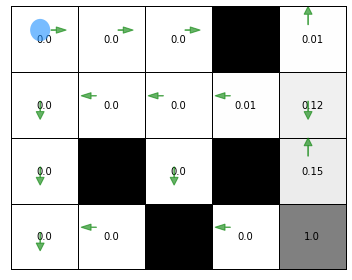

In [6]:
policy = random_policy(mdp)
v = temporal_difference(mdp, policy)

In [7]:
show_videos("videos/", "Temporal")

## Q-learning ##


The **q-learning** algorithm accounts for an agent exploring an MDP and updating at each step a model of the state action-value function stored into a Q-table. It is updated as follows:

$$\delta_t = r(s_t,a_t) + \gamma \max_{a \in A} Q^{(t)}(s_{t+1},a)-Q^{(t)}(s_t,a_t)$$

$$Q^{(t+1)}(s_t,a_t) = Q^{(t)}(s_t,a_t) + \alpha \delta_t.$$


To visualize the policy, we need the `get_policy_from_q(q)` function that we defined in the dynamic programming notebook. Import it below.

In [8]:
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values
    return np.argmax(q,axis=1)

**Question:**  Fill the code of the `q_learning(...)` function below.

In [9]:
# --------------------------- Q-Learning epsilon-greedy version -------------------------------#

# Given an exploration rate epsilon, the QLearning algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate


def q_learning_eps(
    mdp: Mdp,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.new_render("Q-learning e-greedy")

    for _ in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True)
        done = mdp.done()
        while not done:
            if render:
                # Show the agent in the maze
                mdp.render(q, q.argmax(axis=1))

            # Draw an action using an epsilon-greedy policy
            u = egreedy(q, x, epsilon)

            # Perform a step of the MDP
            [y, r, done, _] = mdp.step(u)

            # Update the state-action value function with q-Learning
            if x in mdp.terminal_states:
                q[x, u] = r
            else:
                delta = r + mdp.gamma * np.max(q[y,:]) - q[x, u]
                q[x, u] = q[x, u] + alpha * delta

            # Update the agent position
            x = y
        q_list.append(np.linalg.norm(np.maximum(q, q_min)))

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.render(q, get_policy_from_q(q), title="Q-learning e-greedy")
    return q, q_list

And run it.

/usr/local/lib/python3.7/dist-packages/mazemdp/maze_plotter.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.axes_history.append(self.figure_history[-1].add_subplot(111))


  0%|          | 0/20 [00:00<?, ?it/s]

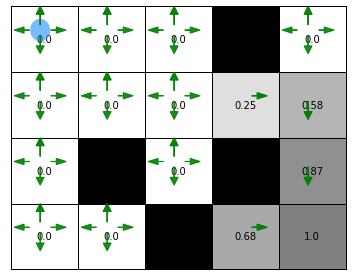

In [10]:
epsilon = 0.02
q, q_list = q_learning_eps(mdp, epsilon)

In [11]:
show_videos("videos/", "Q-learning")

Converting videos/Q-learninge-greedy.avi


### Learning dynamics###


By watching carefully the values while the agent is learning, you can see that the agent favors certains paths over others which have a strictly equivalent value. This can be explained easily: as the agent chooses a path for the first time, it updates the values along that path, these values get higher than the surrounding values, and the agent chooses the same path again and again, increasing the phenomenon. Only steps of random exploration can counterbalance this effect, but they do so extremely slowly.

### Exploration ###


In the `q_learning(...)` function above, action selection is based on a `softmax` policy. Instead, it could have relied on *$\epsilon$-greedy*.


**Question:** In the function below, you have to replace the call to the previous *$\epsilon$-greedy* policy with a `softmax` policy. The `softmax(...)` and `egreedy(...)` functions are available in `mazemdp.toolbox`.

In [12]:
# --------------------------- Q-Learning softmax version ----------------------------#

# Given a temperature "tau", the QLearning algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate
def q_learning_soft(
    mdp: Mdp,
    tau: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.new_render("Q-learning softmax")

    for _ in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True)
        done = mdp.done()
        while not done:
            if render:
                # Show the agent in the maze
                mdp.render(q, q.argmax(axis=1))

            # Draw an action using a soft-max policy
            u = np.random.choice(mdp.action_space.actions, p=softmax(q, x, tau))

            # Perform a step of the MDP
            [y, r, done, _] = mdp.step(u)

            # Update the state-action value function with q-Learning
            if x in mdp.terminal_states:
                q[x, u] = r
            else:
                delta = r + mdp.gamma * np.max(q[y,:]) - q[x, u]
                q[x, u] = q[x, u] + alpha * delta

            # Update the agent position
            x = y
        q_list.append(np.linalg.norm(np.maximum(q, q_min)))

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.render(q, get_policy_from_q(q), title="Q-learning softmax")
    return q, q_list


Run this new version

/usr/local/lib/python3.7/dist-packages/mazemdp/maze_plotter.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.axes_history.append(self.figure_history[-1].add_subplot(111))


  0%|          | 0/20 [00:00<?, ?it/s]

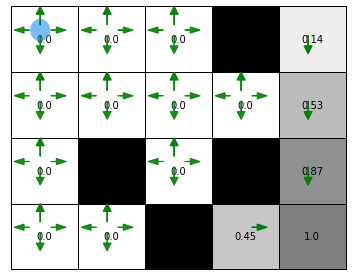

In [13]:
tau = 0.02
q, q_list = q_learning_soft(mdp, tau)

In [14]:
show_videos("videos/", "Q-learningsoftmax")

## Sarsa ##


The **sarsa** algorithm is very similar to **q-learning**. At first glance, the only difference is in the update rule. However, to perform the update in **sarsa**, one needs to know the action the agent will take when it will be at the next state, even if the agent is taking a random action.

This implies that the next state action is determined in advance and stored for being played at the next time step.


**Question:** Fill the code below

In [15]:
# --------------------------- Sarsa, epsilon-greedy version -------------------------------#

# Given an exploration rate epsilon, the SARSA algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate
def sarsa_eps(
    mdp: Mdp,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.new_render("Sarsa e-greedy")

    for _ in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True)
        done = mdp.done()
        while not done:  # update episode at each timestep
            # Show agent
            if render:
                mdp.render(q, q.argmax(axis=1))

            # Draw an action using an epsilon-greedy policy
            u = egreedy(q, x, epsilon)

            [y, r, done, _] = mdp.step(u)

            # Update the state-action value function with q-Learning
            if x in mdp.terminal_states:
                q[x, u] = r
            else:
                v = egreedy(q, y, epsilon)
                delta = r + mdp.gamma * q[y,v] - q[x, u]
                q[x, u] = q[x, u] + alpha * delta

            # Update the agent position
            x = y
        q_list.append(np.linalg.norm(np.maximum(q, q_min)))

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.render(q, get_policy_from_q(q), title="Sarsa e-greedy")
    return q, q_list

And run it.

/usr/local/lib/python3.7/dist-packages/mazemdp/maze_plotter.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.axes_history.append(self.figure_history[-1].add_subplot(111))


  0%|          | 0/20 [00:00<?, ?it/s]

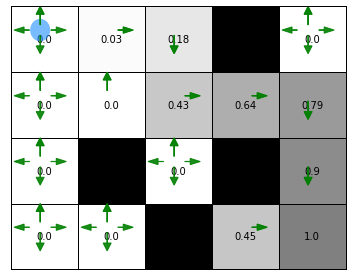

In [16]:
epsilon = 0.02
q, q_list = sarsa_eps(mdp, epsilon)

In [17]:
show_videos("videos/", "Sarsae")

As for **q-learning** above, copy-paste the resulting code to get a *sarsa_soft(...)* and a *sarsa_eps(...)* function.

In [18]:
# --------------------------- Sarsa, softmax version -------------------------------#

# Given a temperature "tau", the SARSA algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate
def sarsa_soft(
    mdp: Mdp,
    tau: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:

    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.new_render("Sarsa softmax")

    for _ in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True)
        done = mdp.done()
        while not done:  # update episode at each timestep
            # Show agent
            if render:
                mdp.render(q, q.argmax(axis=1))

            # Draw an action using an epsilon-greedy policy
            u = np.random.choice(mdp.action_space.actions, p=softmax(q, x, tau))

            [y, r, done, _] = mdp.step(u)

            # Update the state-action value function with q-Learning
            if x in mdp.terminal_states:
                q[x, u] = r
            else:
                v = np.random.choice(mdp.action_space.actions, p=softmax(q, y, tau))
                delta = r + mdp.gamma * q[y,v] - q[x, u]
                q[x, u] = q[x, u] + alpha * delta

            # Update the agent position
            x = y

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.render(q, get_policy_from_q(q), title="Sarsa softmax")
    return q, q_list


And run it.

/usr/local/lib/python3.7/dist-packages/mazemdp/maze_plotter.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.axes_history.append(self.figure_history[-1].add_subplot(111))


  0%|          | 0/20 [00:00<?, ?it/s]

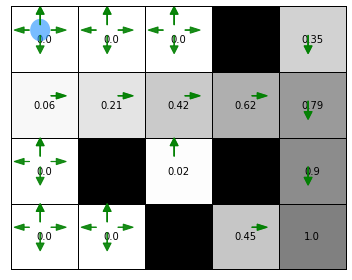

In [19]:
tau = 0.02
q, q_list = sarsa_soft(mdp, tau)

In [20]:
show_videos("videos/", "Sarsasoftmax")

## Study part

### Impact of `epsilon` and `beta` on q-learning and sarsa

Compare the number of steps needed by **q-learning** and **sarsa** to converge on a given MDP using the *softmax* and *$\epsilon$-greedy* exploration strategies. To figure out, you can use the provided `plot_ql_sarsa(m, epsilon, tau, nb_episodes, timeout, alpha, render)` function below with various values for $\epsilon$ (e.g. 0.001, 0.01, 0.1) and $\tau$ (e.g. 0.1, 5, 10) and comment the obtained curves. Other visualizations are welcome.

In [21]:

# -------- plot learning curves of Q-Learning and Sarsa using epsilon-greedy and softmax ----------#

def plot_ql_sarsa(m, epsilon, tau, nb_episodes, timeout, alpha, render):
    q, q_list1 = q_learning_eps(m, epsilon, nb_episodes, timeout, alpha, render)
    q, q_list2 = q_learning_soft(m, tau, nb_episodes, timeout, alpha, render)
    q, q_list3 = sarsa_eps(m, epsilon, nb_episodes, timeout, alpha, render)
    q, q_list4 = sarsa_soft(m, tau, nb_episodes, timeout, alpha, render)

    plt.clf()
    plt.plot(range(len(q_list1)), q_list1, label='q-learning epsilon')
    plt.plot(range(len(q_list2)), q_list2, label='q-learning tau')
    plt.plot(range(len(q_list3)), q_list3, label='sarsa epsilon')
    plt.plot(range(len(q_list4)), q_list4, label='sarsa tau')

    plt.xlabel('Number of episodes')
    plt.ylabel('Norm of Q values')
    plt.legend(loc='upper right')
    plt.savefig("comparison_RL.png")
    plt.title("Comparison of convergence rates")
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

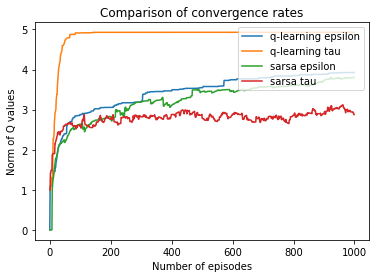

In [22]:
# example
epsilon = 0.02
plot_ql_sarsa(mdp, epsilon, 6, 1000, 50, 0.5, False)

### Effect of hyper-parameters

The other two hyper-parameters of **q-learning** and **sarsa** are $\alpha$, and $\gamma$. By varying the values of these hyper-parameters and watching the learning process and behavior of the agent, explain their impact on the algorithm. Using additional plotting functions is also welcome.